Polinômio da série de Taylor:
0.5*x + 1*x**2 + 1.38778e-07*x**3 + -1.33458*x**4


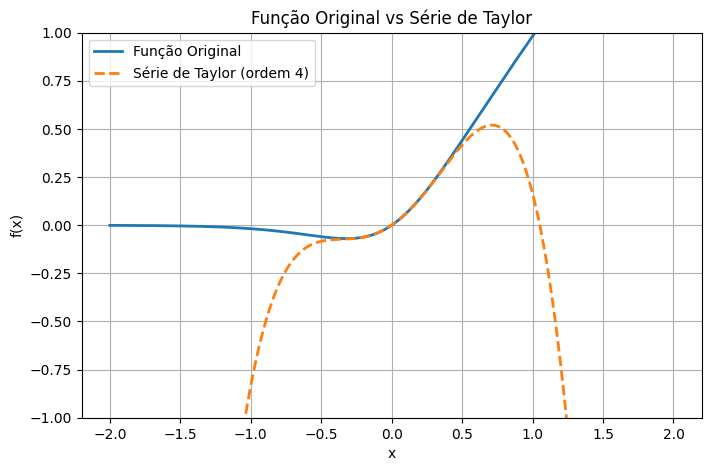

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import math  # <--- necessário para factorial

def taylor_series_numeric(f, a, n, h=1e-5):
    """
    Calcula numericamente os coeficientes da série de Taylor de f(x) em torno de a.
    """
    coeffs = []
    
    for i in range(n + 1):
        # Derivada numérica de ordem i usando diferenças finitas centrais
        def derivative(x, order=i):
            if order == 0:
                return f(x)
            else:
                return (derivative(x + h, order-1) - derivative(x - h, order-1)) / (2*h)
        
        c = derivative(a) / math.factorial(i)  # <--- corrigido
        coeffs.append(c)
    
    return coeffs

def print_polynomial(coeffs):
    terms = []
    for i, c in enumerate(coeffs):
        if abs(c) < 1e-12:
            continue
        term = f"{c:.6g}"
        if i == 1:
            term += "*x"
        elif i > 1:
            term += f"*x**{i}"
        terms.append(term)
    poly = " + ".join(terms)
    print("Polinômio da série de Taylor:")
    print(poly)

def evaluate_polynomial(coeffs, x):
    """Avalia o polinômio em x"""
    result = np.zeros_like(x)
    for i, c in enumerate(coeffs):
        result += c * x**i
    return result

def wsilu(x):
    # Garante que x é um array NumPy (ou número)
    x = np.array(x, dtype=float)
    return x*(1 / (1 + np.exp(-4*x)))

# --- Exemplo de uso ---
f = wsilu     # função original
a = 0             # ponto de expansão
n = 4             # ordem da série
coeffs = taylor_series_numeric(f, a, n)

# Imprime o polinômio
print_polynomial(coeffs)

# Define intervalo para plot
X = np.linspace(-2, 2, 400)
Y_func = f(X)
Y_taylor = evaluate_polynomial(coeffs, X)

# Plota
plt.figure(figsize=(8,5))
plt.plot(X, Y_func, label="Função Original", linewidth=2)
plt.plot(X, Y_taylor, label=f"Série de Taylor (ordem {n})", linestyle='--', linewidth=2)
plt.title("Função Original vs Série de Taylor")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.ylim(-1, 1)  # por exemplo, mínimo -1 e máximo 2
plt.show()



In [69]:
import numpy as np
from numpy.polynomial import Polynomial, Chebyshev

def remez_minimax(f, a, b, deg, iters=15, grid=20001):
    """
    Aproxima f(x) em [a,b] com polinômio de grau 'deg' usando algoritmo de Remez simplificado.
    Retorna um objeto Polynomial (coeficientes em ordem crescente).
    """
    # aproximação inicial via Chebyshev
    xs = np.linspace(a, b, 2001)
    ys = f(xs)
    poly = Chebyshev.fit(xs, ys, deg, domain=[a,b]).convert(kind=Polynomial)

    xs_dense = np.linspace(a, b, grid)
    prev_err = None

    for _ in range(iters):
        err = poly(xs_dense) - f(xs_dense)

        # encontra picos locais do erro
        peaks = [0]
        for i in range(1, len(err)-1):
            if (err[i] >= err[i-1] and err[i] >= err[i+1]) or \
               (err[i] <= err[i-1] and err[i] <= err[i+1]):
                peaks.append(i)
        peaks.append(len(err)-1)

        # seleciona n+2 picos mais fortes
        peaks = sorted(peaks, key=lambda i: -abs(err[i]))[:deg+2]
        peaks = sorted(peaks)
        x_pts = xs_dense[peaks]
        y_pts = f(x_pts)

        # alternância de sinais
        signs = np.array([(-1)**i for i in range(len(x_pts))])

        # resolve sistema linear para coeficientes + erro
        A = np.vander(x_pts, N=deg+1, increasing=True)
        M = np.hstack([A, signs[:,None]])
        sol, *_ = np.linalg.lstsq(M, y_pts, rcond=None)
        coeffs, E = sol[:-1], sol[-1]

        poly = Polynomial(coeffs)

        # checa convergência
        max_err = np.max(np.abs(poly(xs_dense) - f(xs_dense)))
        if prev_err is not None and abs(prev_err - max_err) < 1e-12:
            break
        prev_err = max_err

    return poly

# ================== EXEMPLO ==================
f = lambda x: x / (1 + np.exp(-4*x))

# intervalo e grau
a, b = -1.2, 1.2
deg = 5

p = remez_minimax(f, a, b, deg)

print("Coeficientes (c0..c5):")
print(p.coef)

# medir erro
xs = np.linspace(a, b, 10001)
err = p(xs) - f(xs)
print("Erro máximo:", np.max(np.abs(err)))
print("RMSE:", np.sqrt(np.mean(err**2)))


Coeficientes (c0..c5):
[ 1.51266388e-02  5.00000000e-01  6.93505648e-01  1.97810062e-16
 -2.11562739e-01 -3.71834208e-16]
Erro máximo: 0.015126638753779198
RMSE: 0.01064418334924854


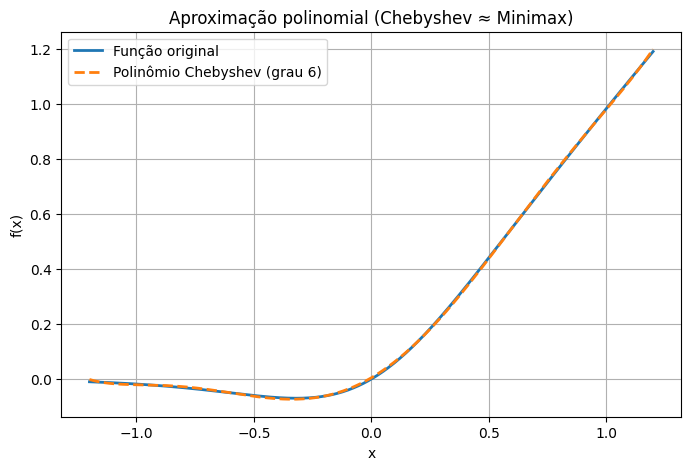

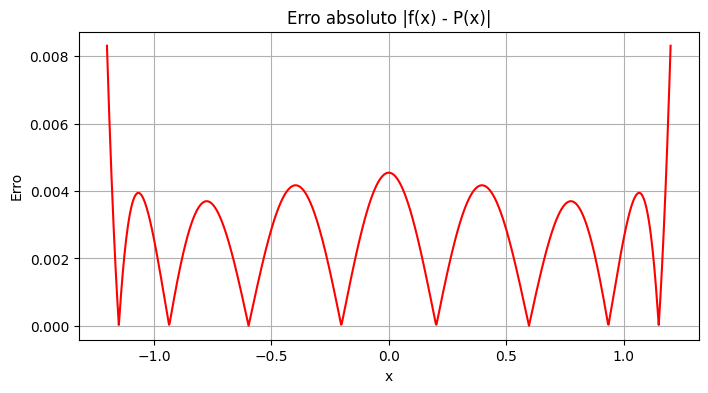

Coeficientes do polinômio (em base Chebyshev):
[ 3.50549398e-01  6.00000000e-01  2.81232207e-01  5.85938705e-17
 -4.90158955e-02  2.78965608e-16  1.57547689e-02]

Polinômio em base padrão:
0.00454653 + 0.5·x + 0.85984543·x² - (3.09313465e-15)·x³ - 0.55379826·x⁴ +
(1.79376034e-15)·x⁵ + 0.16883969·x⁶

Erro máximo absoluto: 0.008316
Erro quadrático médio (RMSE): 0.002971


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev, Polynomial

# Função alvo
def f(x):
    return x / (1 + np.exp(-4*x))

# Intervalo
a, b = -1.2, 1.2

# Grau do polinômio
n = 6

# Gera pontos da função no intervalo
X_sample = np.linspace(a, b, 500)
Y_sample = f(X_sample)

# Ajusta polinômio de Chebyshev
cheb_poly = Chebyshev.fit(X_sample, Y_sample, deg=n, domain=[a, b])

# Para plotagem e cálculo de erro
X = np.linspace(a, b, 1000)
Y_true = f(X)
Y_poly = cheb_poly(X)

# Cálculo dos erros
erro_absoluto = np.abs(Y_true - Y_poly)
erro_max = np.max(erro_absoluto)          # Erro absoluto máximo
erro_rmse = np.sqrt(np.mean(erro_absoluto**2))  # Erro quadrático médio

# Plot
plt.figure(figsize=(8,5))
plt.plot(X, Y_true, label="Função original", linewidth=2)
plt.plot(X, Y_poly, "--", label=f"Polinômio Chebyshev (grau {n})", linewidth=2)
plt.title("Aproximação polinomial (Chebyshev ≈ Minimax)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

# Plot do erro
plt.figure(figsize=(8,4))
plt.plot(X, erro_absoluto, color="red")
plt.title("Erro absoluto |f(x) - P(x)|")
plt.xlabel("x")
plt.ylabel("Erro")
plt.grid(True)
plt.show()

# Mostra os resultados
print("Coeficientes do polinômio (em base Chebyshev):")
print(cheb_poly.coef)

poly_std = cheb_poly.convert(kind=Polynomial)
print("\nPolinômio em base padrão:")
print(poly_std)

print(f"\nErro máximo absoluto: {erro_max:.6f}")
print(f"Erro quadrático médio (RMSE): {erro_rmse:.6f}")


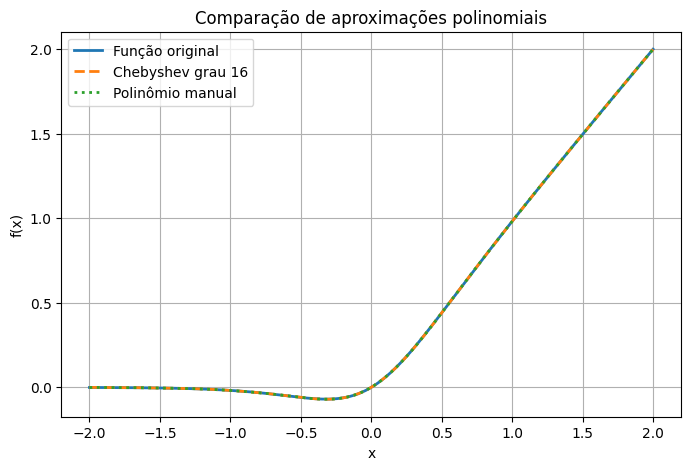

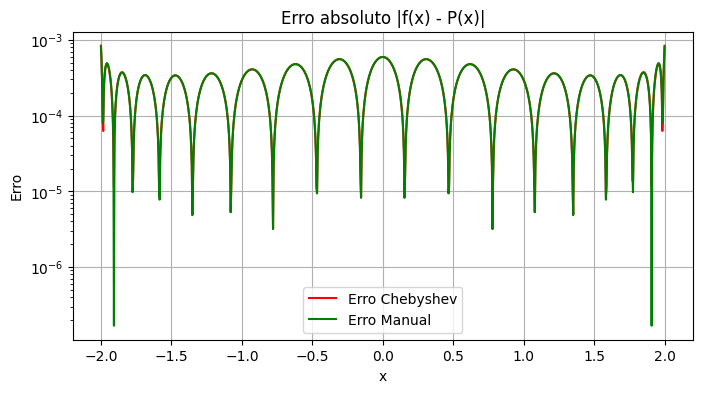

Polinômio Chebyshev (grau 16):
0.00059508 + 0.5·x + 0.96917012·x² - (7.1236302e-15)·x³ - 1.04954556·x⁴ +
(4.14849136e-14)·x⁵ + 0.99181597·x⁶ - (6.5173149e-14)·x⁷ - 0.63088907·x⁸ +
(4.59505327e-14)·x⁹ + 0.25503359·x¹⁰ - (1.62828316e-14)·x¹¹ -
0.06236471·x¹² + (2.83279803e-15)·x¹³ + 0.0083775·x¹⁴ -
(1.92515067e-16)·x¹⁵ - 0.00047333·x¹⁶
Erro máximo: 0.000837, RMSE: 0.000317

Polinômio manual (coeficientes = [0.00059508, 0.5, 0.96917012, 0.0, -1.04954556, 0.0, 0.99181597, 0.0, -0.63088907, 0.0, 0.25503359, 0.0, -0.06236471, 0.0, 0.0083775, 0.0, -0.00047333])
0.00059508 + 0.5·x + 0.96917012·x² + 0.0·x³ - 1.04954556·x⁴ + 0.0·x⁵ +
0.99181597·x⁶ + 0.0·x⁷ - 0.63088907·x⁸ + 0.0·x⁹ + 0.25503359·x¹⁰ +
0.0·x¹¹ - 0.06236471·x¹² + 0.0·x¹³ + 0.0083775·x¹⁴ + 0.0·x¹⁵ -
0.00047333·x¹⁶
Erro máximo: 0.000813, RMSE: 0.000317


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev, Polynomial

# ===============================
# Função alvo
# ===============================
def f(x):
    return x / (1 + np.exp(-4*x))

# Intervalo
a, b = -2, 2

# Grau do polinômio
n = 16

# ===============================
# Aproximação via Chebyshev
# ===============================
X_sample = np.linspace(a, b, 500)
Y_sample = f(X_sample)

cheb_poly = Chebyshev.fit(X_sample, Y_sample, deg=n, domain=[a, b])

# Converter para polinômio padrão
poly_std = cheb_poly.convert(kind=Polynomial)

# ===============================
# Polinômio manual (opcional)
# ===============================
# Coloque aqui os coeficientes do polinômio que você quiser testar
# Exemplo: [c0, c1, c2, ...] para c0 + c1*x + c2*x^2 + ...
coef_manuais = [0.00059508000000000000,  
0.50000000000000000000,  
0.96917012000000000000,  
0.00000000000000000000,  
-1.04954556000000000000,  
0.00000000000000000000,  
0.99181597000000000000,  
0.00000000000000000000,  
-0.63088907000000000000,  
0.00000000000000000000,  
0.25503359000000000000,  
0.00000000000000000000,  
-0.06236471000000000000,  
0.00000000000000000000,  
0.00837750000000000000,  
0.00000000000000000000,  
-0.00047333000000000000  
]
#poly_manual = Polynomial(coef_manuais, domain=[a, b])
poly_manual = Polynomial(coef_manuais)  # sem domain

# ===============================
# Avaliação e Erro
# ===============================
X = np.linspace(a, b, 1000)
Y_true = f(X)
Y_poly_auto = poly_std(X)
Y_poly_manual = poly_manual(X)

# Erro Chebyshev
erro_auto = np.abs(Y_true - Y_poly_auto)
erro_auto_max = np.max(erro_auto)
erro_auto_rmse = np.sqrt(np.mean(erro_auto**2))

# Erro Manual
erro_manual = np.abs(Y_true - Y_poly_manual)
erro_manual_max = np.max(erro_manual)
erro_manual_rmse = np.sqrt(np.mean(erro_manual**2))

# ===============================
# Plots
# ===============================
plt.figure(figsize=(8,5))
plt.plot(X, Y_true, label="Função original", linewidth=2)
plt.plot(X, Y_poly_auto, "--", label=f"Chebyshev grau {n}", linewidth=2)
plt.plot(X, Y_poly_manual, ":", label="Polinômio manual", linewidth=2)
plt.title("Comparação de aproximações polinomiais")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

plt.show()

# Erro Chebyshev
plt.figure(figsize=(8,4))
plt.plot(X, erro_auto, label="Erro Chebyshev", color="red")
plt.plot(X, erro_manual, label="Erro Manual", color="green")
plt.title("Erro absoluto |f(x) - P(x)|")
plt.xlabel("x")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.show()

# ===============================
# Resultados numéricos
# ===============================
print("Polinômio Chebyshev (grau {}):".format(n))
print(poly_std)
print(f"Erro máximo: {erro_auto_max:.6f}, RMSE: {erro_auto_rmse:.6f}")

print("\nPolinômio manual (coeficientes = {})".format(coef_manuais))
print(poly_manual)
print(f"Erro máximo: {erro_manual_max:.6f}, RMSE: {erro_manual_rmse:.6f}")

def WSiLU_polinomial(x):
    if(x<-1.2):
        return 0
    if(x>1.2):
        return x 
    return 0.004546 + 0.5*x + 0.859845*x**2 - 0.553798*x**4 + 0.168839*x**6


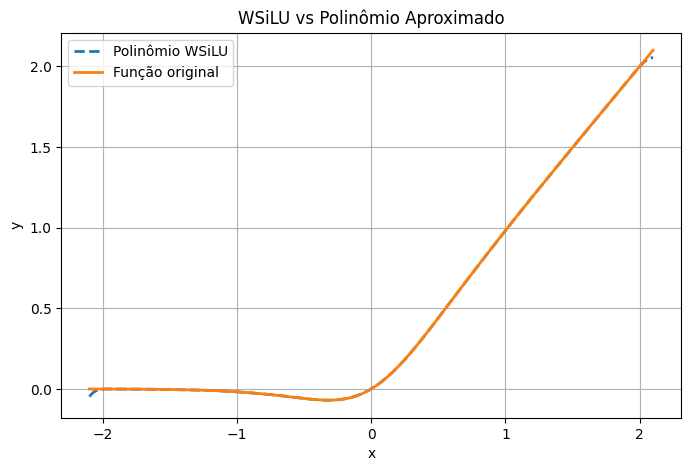

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Função polinomial que você forneceu
def WSiLU_polinomial(x):
    x = np.array(x, dtype=float)
    return 0.00059508 + 0.5*x + 0.96917012*x**2 - 1.04954556*x**4  + 0.99181597*x**6 - 0.63088907*x**8 + 0.25503359*x**10 - 0.06236471*x**12 + 0.0083775*x**14 - 0.00047333*x**16

# Função original (opcional, para comparar)
def WSiLU_original(x):
    x = np.array(x, dtype=float)
    return x / (1 + np.exp(-4*x))

# Intervalo de x para plot
x = np.linspace(-2.1, 2.1, 500)

# Calcula os valores
y_poly = WSiLU_polinomial(x)
y_orig = WSiLU_original(x)

# Plotando
plt.figure(figsize=(8,5))
plt.plot(x, y_poly, "--", label="Polinômio WSiLU", linewidth=2)
plt.plot(x, y_orig, label="Função original", linewidth=2)
plt.title("WSiLU vs Polinômio Aproximado")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()
0.00059508 + 0.5*x + 0.96917012*x**2 - 1.04954556*x**4  + 0.99181597*x**6 - 0.63088907*x**8 + 0.25503359*x**10 - 0.06236471*x**12 + 0.0083775*x**14 - 0.00047333*x**16

In [ ]:
# 6 graus, de -1.2 a 1.2

def WSiLU_polinomial(x):
    if(x<-1.2):
        return 0
    if(x>1.2):
        return x 
    return 0.004546 + 0.5*x + 0.859845*x**2 - 0.553798*x**4 + 0.168839*x**6


3

In [ ]:
# 16 graus, de -2 a 2
def WSiLU_polinomial(x):
    if(x<-2):
        return 0
    if(x>2):
        return x 
    return 0.00059508 + 0.5*x + 0.96917012*x**2 - 1.04954556*x**4  + 0.99181597*x**6 - 0.63088907*x**8 + 0.25503359*x**10 - 0.06236471*x**12 + 0.0083775*x**14 - 0.00047333*x**16


0